<a href="https://colab.research.google.com/github/jefferson-spec/jeeh_data_science/blob/master/S%C3%A9ries_Temporais_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Séries Temporais com o Prophet

Neste projeto, trabalharemos com séries temporais (*time series*) e a ferramenta ***Prophet***. Especificamente, faremos a previsão relacionada ao desfecho (*outcomes*) de animais em um abrigo

Antes de entrar no projeto em si, vamos conhecer o Prophet e o motivo dele ser tão poderoso para lidar com dados temporais.

## Prophet e Séries Temporais

Fazer boas previsões com dados temporais é uma tarefa altamente complexa. Dada a complexidade dos modelos estatísticos, *time series* representam um desafio para engenheiros de *machine learning*, estatísticos e economistas.

Tentar implementar um modelo sem usar nenhum *framework*, implica entender profundamente uma teoria que não é trivial e que exige um certo grau de especialização.

***Prophet***é um *framework* de forecasting* para séries temporais, disponibilizado como projeto *open source* pelo **Facebook**. Implementado em Python e R, é capaz de realizar previsões automatizadas e rápidas.

<p align="center"><img src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/prophet.png" height="300px"></p>

Como nem todos os problemas de *time series* podem ser resolvidos da mesma maneira - e o Prophet foi desenvolvido pensando-se nos problemas internos do Facebook -, é possível que cientistas e analistas de dados otimizem parâmetros do *framework*.

Para ter acesso a documentação oficial do projeto, basta [acessar esta página.](https://facebook.github.io/prophet/). Apesar de não haver muitos projetos e tutoriais, recomenda-se conhecer as customizações possíveis do modelo.

### Modelo Preditivo do Prophet

Como dissemos acima, o Prophet foi feito para solucionar problemas do Facebook. Ou seja, é muito forte para lidar com problemas que tenham características como:

* Dados coletados por um longo período (meses ou anos), e que possuam o maior detalhamento histórico possível.
* Sazonalidades fortes e destacadas.
* Feriados ou datas especiais conhecidas *a priori*.
* Tendência de crescimento não linear, que se aproxima de um limite.

Propeht usa um modelo de séries temporais decomposto, com três componentes principais: tendência, sazonalidade e feriados:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

onde:

* $g(t)$ é a tendência, que modela as mudanças não-periódicas no valor da série temporal;
* $s(t)$ representa as mudanças periódicas (como sazonalidade semanal, anual, etc);
* $h(t)$ representa os efeitos dos feriados; e
* $\varepsilon_t$ é o erro, as mudanças que não são capturadas pelo modelo (assume-se esse como tendo uma distribuição normal).

Lembrando, os parâmetros que estão definidos como *standard* atendem bem a maioria dos casos. No entanto, caso não tenham um *fit* adequado ao seu problema, esses podem ser ajustados manualmente.


## O Problema de um Abrigo de Animais

O Centro de animais de Austin, no Texas, provê abriga para mais de 16 mil animais por ano, além de outros serviços envolvendo proteção de animais - independente da raça, idade ou estado de saúde desses.

Tendo como principal objetivo "destinar todos os animais possíveis para um novo lar, seja por meio de adoção, assistência social ou grupos de resgate.

Apesar desse objetivo, não é possível conseguir um lar para todos esse animais, e muitos acabam sendo sacrificados. A meta do Austin Animal Center é conseguir que o desfecho positivo, ou seja a saída com vida desses animais, seja superior a 90% do total.

Neste projeto, iremos analisar as saídas com vida desses animais. Com essa análise, espera-se que sejamos capazes de identificar um padrão de adoção.

Mais que identificar um padrão, espera-se fazer previsões futuras em relação ao número de saídado Austin Animal Center, visando:

1. Planejar compras de insumos (remédios, comida, etc);
2. Contratação de funcionários e colaboradores; e
3. Fazer campanhas visando otimizar a adoção de animais.

### Aquisição dos Dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* foi atualizado em 17 de Maio de 2020 e contém **118K linhas** e **12 colunas**, onde  

In [0]:
# importat bibliotecas necessárias 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


In [0]:
# configurar visualização de dados 
%matplotlib inline
%config InlineBackend.figure_format ='svg'

In [4]:
# Importar dados do DataFrame
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Science Sigmoidal/Austin_Animal_Center_Outcomes.csv')

#Converter coluna para o formato Datatime
df.DateTime = pd.to_datetime(df.DateTime)
# Ver as primeiras 5 entradas
df.head()


,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


## Análise Exploratoria

In [5]:
# ver o resumo das principais informações estatisticas
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,117659,80790,117659,117659,117659,117651,53437,117659,117656,117609,117659,117659
unique,105193,18910,96928,96928,6826,9,22,5,5,50,2568,585
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,04/21/2014,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,527,39,39,117,51831,29184,66926,41308,21188,30758,12369
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-05-17 16:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#ver o resumo dos tipos de variaveis e valores não-nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117659 entries, 0 to 117658
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117659 non-null  object        
 1   Name              80790 non-null   object        
 2   DateTime          117659 non-null  datetime64[ns]
 3   MonthYear         117659 non-null  object        
 4   Date of Birth     117659 non-null  object        
 5   Outcome Type      117651 non-null  object        
 6   Outcome Subtype   53437 non-null   object        
 7   Animal Type       117659 non-null  object        
 8   Sex upon Outcome  117656 non-null  object        
 9   Age upon Outcome  117609 non-null  object        
 10  Breed             117659 non-null  object        
 11  Color             117659 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.8+ MB


In [7]:
#verificar se há dados ausentes
df.isnull().sum()

Animal ID               0
Name                36869
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64222
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       50
Breed                   0
Color                   0
dtype: int64

In [8]:
# ver os tipos de outcomes possiveis
df['Outcome Type'].value_counts()

Adoption           51831
Transfer           34958
Return to Owner    20673
Euthanasia          7913
Died                1079
Rto-Adopt            613
Disposal             497
Missing               67
Relocate              20
Name: Outcome Type, dtype: int64

In [9]:
# Ver apenas os outcomes de adoção e retorno aos donos
adoptions_df = df[(df['Outcome Type'] == 'Adoption')]
adoptions_df['outcomeCount'] = 1

adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [10]:
# ver as data mínimas e máximas
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2020-05-17 15:30:00'))

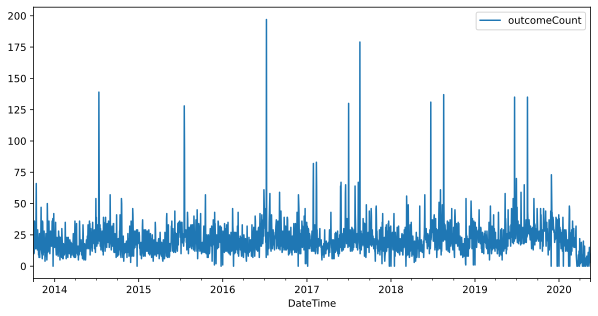

In [11]:
# plotar gráfico diário
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

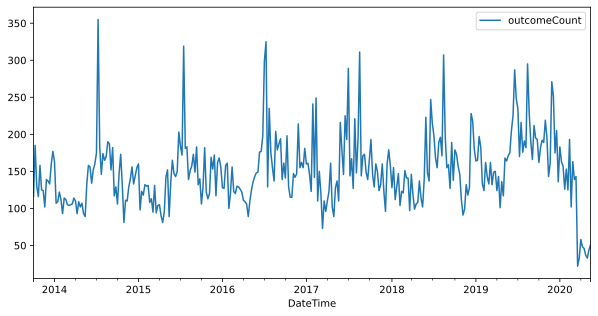

In [12]:
# plotar gráfico semanal
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()

# Preparar os Dados para o  Prophet


In [13]:
#trabalhar com dados diarios
# df
# y 
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime': 'ds', 'outcomeCount' : 'y'})

# ver as 5 primeiraas entradas
prophet_df.head()


,ds,y
0,2013-10-01,11
1,2013-10-02,16
2,2013-10-03,10
3,2013-10-04,11
4,2013-10-05,36


## Criar modelo de Forecasting

Modelo Diário

In [14]:
# instanciar e treinar o modelo
model = Prophet()
model.fit(prophet_df)
# determinar o periodo de dias para previsão
future = model.make_future_dataframe(periods=365)

#realizar a previsão para o periodo estabelecido
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


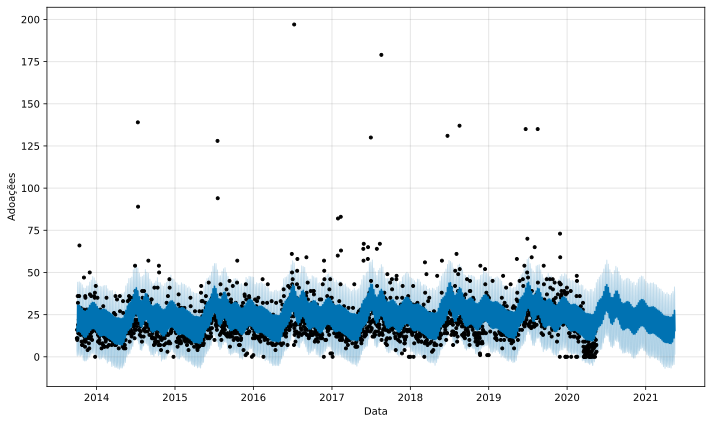

In [15]:
# visualizar o gráfico com as previsão
model.plot(forecast, xlabel='Data', ylabel='Adoaçẽes');

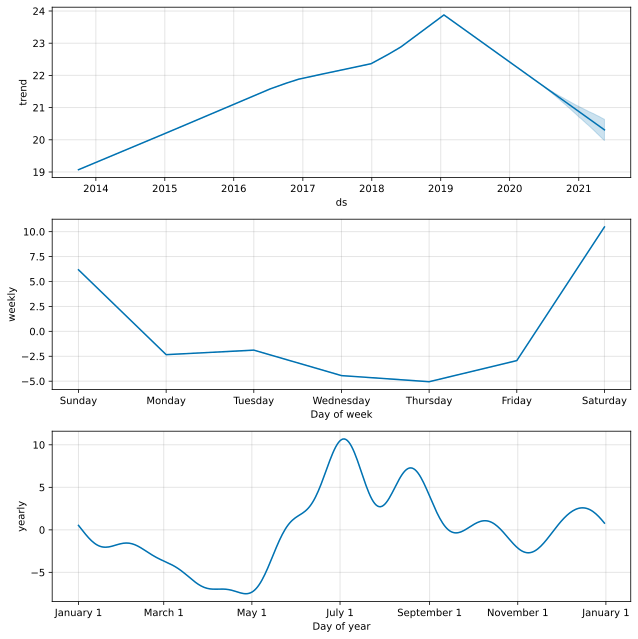

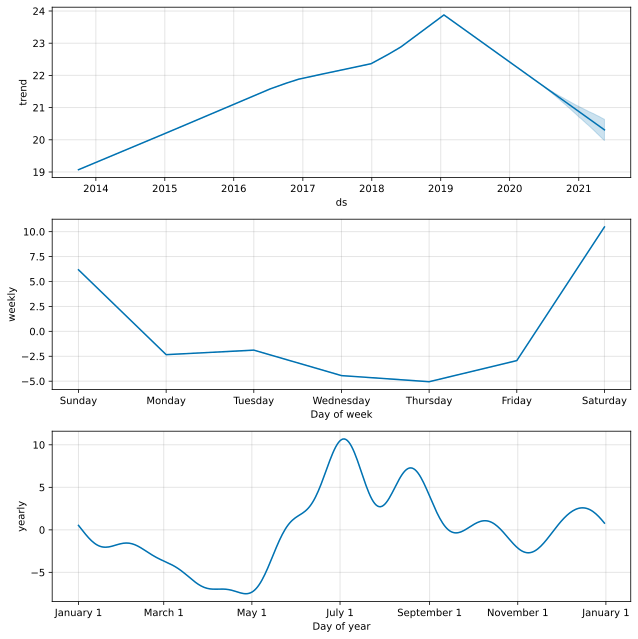

In [16]:
# separar os componentes do modelo
model.plot_components(forecast)

## Modelo Semanal

In [17]:
# criar um modelo baseado em semanas 
prophet_df2 = adoptions_df.resample('W').sum().reset_index().rename(columns={'DateTime': 'ds', 'outcomeCount' : 'y'})

# instanciar e treinar o modelo
model2 = Prophet()
model2.fit(prophet_df2)
# determinar o periodo de dias para previsão
future2 = model2.make_future_dataframe(periods=52)

#realizar a previsão para o periodo estabelecido
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


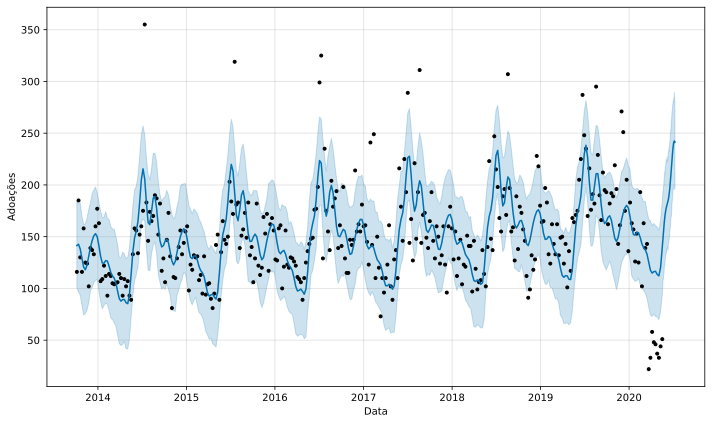

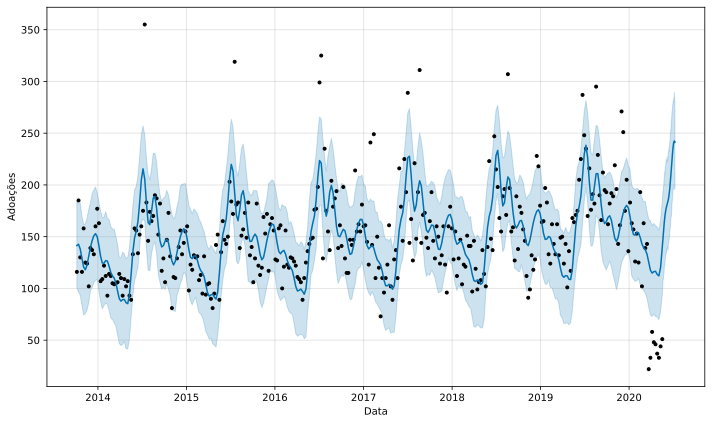

In [18]:
#visualizar o gráfico com as previsão
model2.plot(forecast2, xlabel='Data', ylabel='Adoações')

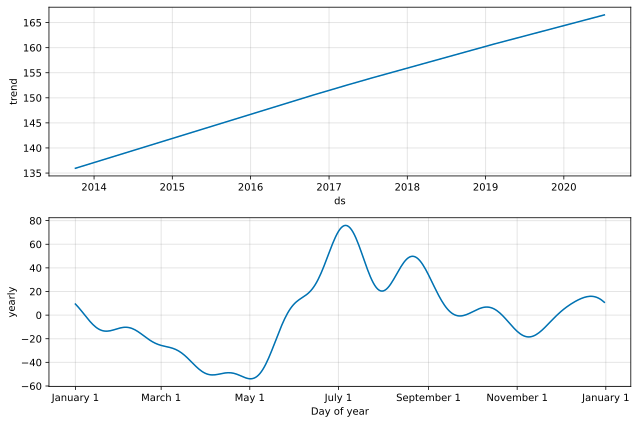

In [19]:
#separar os componentes do modelo
model2.plot_components(forecast2);

## Avaliação do Modelo de Séries Temporais

Modelo Diário

In [20]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon='180 days')
df_cv.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2015-06-13 00:00:00 and 2019-11-19 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-06-14,28.511073,19.157295,38.449565,26,2015-06-13
1,2015-06-15,18.400550,7.707044,28.045110,25,2015-06-13
2,2015-06-16,17.013705,7.033431,27.070265,24,2015-06-13
3,2015-06-17,15.206625,5.614553,24.964502,14,2015-06-13
4,2015-06-18,14.327565,4.187708,24.272965,12,2015-06-13


In [21]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,18 days,77.553915,8.806470,6.659827,0.237416,0.853801
1,19 days,75.761594,8.704114,6.537593,0.228448,0.862573
2,20 days,77.817476,8.821421,6.632984,0.235892,0.856725
3,21 days,86.128599,9.280550,6.746697,0.229516,0.850877
4,22 days,88.046490,9.383309,6.798115,0.227394,0.847953


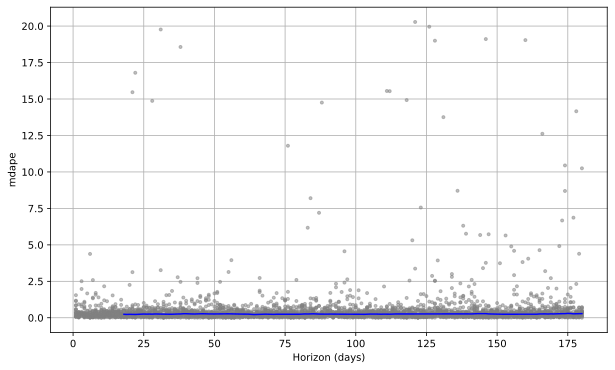

In [24]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mdape')

# Modelo Semanal

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-11-16 12:00:00 and 2019-05-18 00:00:00


           horizon          mse       rmse  ...      mape     mdape  coverage
0 36 days 00:00:00  1513.008851  38.897414  ...  0.206549  0.191903  0.548387
1 36 days 12:00:00  1584.052384  39.800156  ...  0.210968  0.193502  0.516129
2 37 days 00:00:00  1578.143009  39.725848  ...  0.201205  0.191903  0.516129
3 37 days 12:00:00  1508.863091  38.844087  ...  0.187149  0.189498  0.548387
4 38 days 00:00:00  1488.962880  38.587082  ...  0.181790  0.180375  0.548387

[5 rows x 7 columns] 



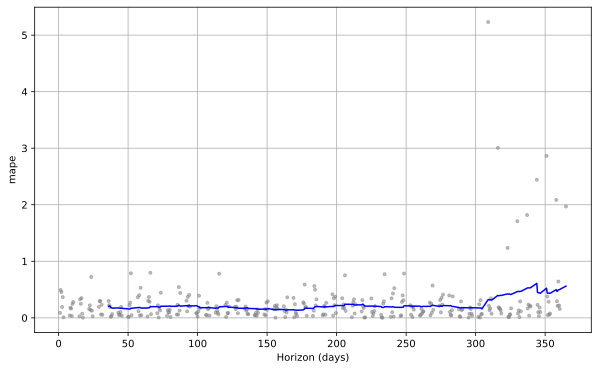

In [26]:
from fbprophet.diagnostics import cross_validation
df_cv2 = cross_validation(model2, horizon = '365 days')
# print(df_cv2.head(), "\n")

from fbprophet.diagnostics import performance_metrics
df_p2 = performance_metrics(df_cv2)
print(df_p2.head(), "\n")

from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv2, metric='mape');

#Feriados e Datas Comemorativas

In [27]:
# Feriados e datas personalizadas
personalizado = pd.DataFrame({
    'holiday': 'Seu Feriado Aqui',
    'ds': pd.to_datetime(['2018-02-07', '2019-02-07', '2020-02-07']),
    'lower_window': 0,
    'upper_window': 1,
})

model = Prophet(holidays=personalizado)
model.add_country_holidays(country_name='BR')
model.fit(prophet_df)
model.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0              Seu Feriado Aqui
1                New Year's Day
2                    Tiradentes
3                  Worker's Day
4              Independence Day
5    Our Lady of the Apparition
6                All Souls' Day
7     Republic Proclamation Day
8                     Christmas
dtype: object